# Lab 6 - Logistic Regression   ( Moses Mbabaali 4846019)

In this lab we implement and use logistic regressione for binary claffication problems.

We start including some libraries and functions already seen in the previous labs (or slight variations of them). Have a look and verify you understand their purpose.

<b>READ all the text parts very carefully, as you will find instructions on how to proceed.</b>

In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata

In [2]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2,
                                                                    size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

In [3]:
def flipLabels(Y, perc):

    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [4]:
def separatingFLR(Xtr, Ytr, Ypred, w):
    
    xi = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), 200)
    yi = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), 200)
    X, Y = np.meshgrid(xi,yi)
    
    zi = griddata(Xtr, Ypred, (X,Y), method='linear')
    
    plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(Xtr[:,0], Xtr[:,1], c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    plt.xlim(Xtr[:,0].min(), Xtr[:,0].max())
    plt.ylim(Xtr[:,1].min(), Xtr[:,1].max())


In [18]:
def linearBinaryClass(n, low_D, high_D, m, q):

    X = np.zeros((n, 2))
    Y = np.zeros(n)
    for i in range(2):
        X[:,i] = np.random.uniform(low_D, high_D, size=n)
        
    Y[X[:,1] - (X[:,0] * m + q) > 0] = 1 
    Y[Y==0] = -1
    
    return X,Y

In [19]:
n = 200
D = 2

m = 0.9
q = 0

low_D = -10
high_D = 10
    
    # Generate a training set WITH NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

### Estimating the function on the training set

We define now the function <b>linearLRTrain(Xtr, Ytr, reg_par)</b> to estimate the classification function on the training set. The use is as follows:
##### w, errs = linearLRTrain(Xtr, Ytr, reg_par)
where
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>Ytr</b> is the n vector of training set outputs
- <b>reg_par</b> is the value of the lammbda
- <b>w</b> is the D vector of the estimated function parameters
- <b>errs</b> is the vector of the errors made, at each iteration, in the function estimation


In [225]:

def linearLRTrain(Xtr, Ytr, reg_par):
  
    epsilon = 1e-6
    iter = 10
    bias = 0
    
    # size of the input in the trainind
    n_values, D_features = np.shape(Xtr)
    
    # initialization of the vector w
    weights = np.zeros(D_features)
    
    # estimation of the gamma parameter (fixed)
    eigvals, eigvects = np.linalg.eig(np.dot(Xtr, np.transpose(Xtr)))
    L = np.max(eigvals.astype(float)) / n + reg_par
    gamma = 1/L
    
    # initialization of some supporting variables
    j=0
    f_old = 0
    f = float("inf")
    
    errs = np.zeros(iter+1)
    
    for i in range(iter):
        j = j+1
     
        model = np.dot(Xtr,weights)
        predicted_y = sigmoid(model)
        
        # Gradient 
        dw = (1/n_values)* np.dot(Xtr.T, (predicted_y-Ytr)) +2*reg_par
        db = (1/n_values)* np.sum(predicted_y-Ytr)
            
        weights -= gamma*dw
        bias -= gamma*db
        
        #print("iter:"+str(j)+" err:"+str(abs(f-f_old)))
        #errs[j] = abs(f-f_old)    
        
    return weights, bias

def sigmoid(Xtr):
    return 1/(1+np.exp(-Xtr))

In [227]:
wts = linearLRTrain(Xtr, Ytr, 0.1)

/home/mb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


### Evaluation the function on the test set

Here we define the function to evaluate the training function on a set of samples. Use it as follows
##### Ypred, Ppred = linearLRTest(w, Xte)
where
- <b>w</b> is the D vector of the estimated function parameters
- <b>Xte</b> is the matrix of input points in the test set
- <b>Ypred</b> is the vector of predictions
- <b>Ppred</b> is a confidence associated with each prediction

In [270]:
def linearLRTest(w, Xte,bias):
    
    model = np.dot(Xte,w)+bias
    Yp = sigmoid(model)
    Ypred = [1 if i>0.5 else -1 for i in Yp]
    
    # Try and understand what it does, deriving the formula
    Ppred = np.divide(np.exp(Ypred), (1 + np.exp(Ypred)))
    
    return np.array(Ypred) , Ppred



In [271]:
Lrtest = linearLRTest(wts[0], Xtr,wts[1])

### Evaluation of the quality of the prediction

We need a way to quantify how good is the estimated function and its predictions. We thus define the following:

##### class_err = calcError(Ypred, Y)
where
- <b>Ypred</b> is the vector of predictions obtained with linearLRTest
- <b>Y</b> is the vector of true labels
- <b>class_err</b> is the percentage of misclassified samples

In [272]:
def calcError(Ypred, Ytrue):
    
    class_err = Ypred - Ytrue
    counttrue = 0
    countfalse = 0
    for i in class_err:
        if i ==0:
            counttrue= counttrue+1
        else:
            countfalse = countfalse+1
            
    return counttrue/class_err.shape[0], countfalse/class_err.shape[0]


calcError(Lrtest[0], Ytr)

(1.0, 0.0)

### Analysis

A guideline maybe the following:

- Build two binary classification datasets, for training and test
- Visualize them (see examples in the notebook of the first lab if you do not remember the syntax)
- Pick a reasonable value for the lambda parameter (e.g. reg_par = 0.1, 0.01,...)
- Run the training
- Plot the errors associated with each iteration
- Show the separating curve corresponding to the obtained w (...what do you expect?)
- Evaluate the estimated function on the test set
- Compute and show training and test classification errors


In [273]:
# ... fill here ...
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

(-10.0, 10.0)

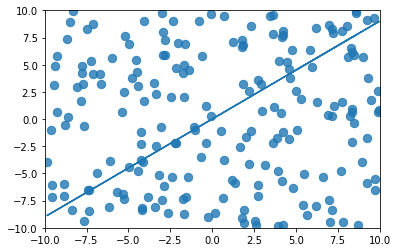

In [274]:
# plot the samples and the separator
Ytr[Xtr[:,1] - (Xtr[:,0] * m + q) > 0] = 1 
Ytr[Ytr==0] = -1

plt.scatter(Xtr[:,0], Xtr[:,1],s=70, alpha=0.8)
plt.plot(Xtr[:,0], Xtr[:,0]* m + q)
plt.xlim((low_D, high_D))
plt.ylim((low_D, high_D))

/home/mb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Error')

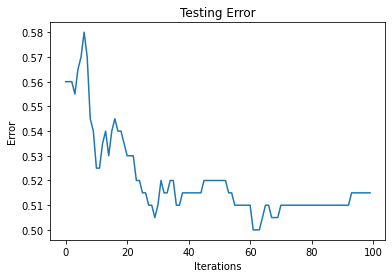

In [275]:
xr = np.arange(0.0, 10.0, 0.1)
Error = []
for i in xr:
    tr = linearLRTrain(Xtr, Ytr, i)
    Lrtest = linearLRTest(tr[0], Xte,tr[1])
    error = calcError(Lrtest[0], Ytr)
    Error.append(error[1])


plt.plot(Error)
plt.title('Testing Error')
plt.xlabel('Iterations')
plt.ylabel('Error')

/home/mb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Error')

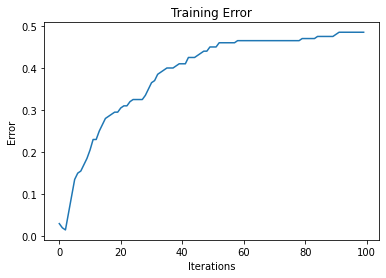

In [277]:
xr = np.arange(0.0, 10.0, 0.1)
Error = []
for i in xr:
    tr = linearLRTrain(Xtr, Ytr, i)
    Lrtest = linearLRTest(tr[0], Xtr,tr[1])
    error = calcError(Lrtest[0], Ytr)
    Error.append(error[1])


plt.plot(Error)
plt.title('Training Error')
plt.xlabel('Iterations')
plt.ylabel('Error')

### What are we still missing?

Think to (and possibly implement) what you should do to select an appropriate value for lambda!!

In [279]:
# The best lambda in my case will be say 0.4
tr = linearLRTrain(Xtr, Ytr, 0.3)
Lrtest = linearLRTest(tr[0], Xtr,tr[1])
calcError(Lrtest[0], Ytr)


/home/mb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


(0.945, 0.055)

In [290]:
# The best lambda in my case will be say 0.001 for the testing set. I would need to do some more tunings
tr = linearLRTrain(Xtr, Ytr, 0.001)
Lrtest = linearLRTest(tr[0], Xte, tr[1])
calcError(Lrtest[0], Ytr)

/home/mb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


(0.44, 0.56)